For this project, I decided to feed the data into a neural network with LSTM cells to predict the time left of a rider's career.  
The data is normalized and transformed from the long-format to a 3-D numpy array. Afterwards, the sequences in this arrray are padded with `-99` to be equal length.  
Finally the model is used to predict the time until the end of career for currently active riders, which can also be explored through an interactive widget.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Masking
from keras.optimizers import RMSprop
from keras import backend as K
from sklearn.preprocessing import normalize
from sklearn import preprocessing

model_path = 'riders_model.h5'

#set seed for random operations
SEED = 13
np.random.seed(SEED)

/anaconda3/envs/my_conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/envs/my_conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/envs/my_conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/envs/my_conda/lib/python3.7/site-packages/tensorflow/python/frame

In [2]:
#load scraped data
#Raw_data = pd.read_feather('Achive/CleanData_allData18V2.feather')
load = pd.read_pickle('CleanData.pkl')




In [3]:
#in order to not load the data again in case of doing any changes to hyperparameters, etc.
Raw_data = load

The data is split into one dataset with all retired riders and one with all active riders.  
The dataset with the retired riders is then split again 80/20 into a trrain and test set.

In [4]:
#Data to look up data
lookup_data = Raw_data
#filter out riders, who still have a contract (event didn't happen yet)
Master_data = Raw_data[Raw_data['UntilEvent'] == -99]
#drop features, which can't be used due to missing data, text or already in use (birthday vs age)
Raw_data = Raw_data.drop(['Team', 'Team Year', 'TeamCat', 'Name', 'Weight', 'Height',
                          'Birthdate','RetirementDate', 'Nationality', 'event', 'start', 'stop'], axis=1)
#gather maximum career length for max numer of sequences
max_batch_len = Raw_data['IDs'].value_counts().max()
#all data
all_data = Raw_data
#filter out riders, who still have a contract (event didn't happen yet)
Active_data = Raw_data[Raw_data['UntilEvent'] == -99]
#filter out riders who already ended their career (event did already happen)
Raw_data = Raw_data[Raw_data['UntilEvent'] != -99]


#Number of riders who ended their career
NoRiders = len(Raw_data['IDs'].value_counts())

#get test and train set by ID
from sklearn.model_selection import GroupShuffleSplit
train_inds, test_inds = next(GroupShuffleSplit(test_size=.20, n_splits=2, random_state = SEED).split(Raw_data, groups=Raw_data['IDs']))

train = Raw_data.iloc[train_inds]
test = Raw_data.iloc[test_inds]


In [5]:
def normalize_riders(df, cols_ignore=['IDs','CareerLength','UntilEvent']):
    """
    Normalize a dataframe, but ignore colums such as ID, CareerLength, etc.
    """
    cols_norm = df.columns.difference(cols_ignore)
    min_max_scaler = preprocessing.MinMaxScaler()
    norm_df = pd.DataFrame(min_max_scaler.fit_transform(df[cols_norm]),
                           columns=cols_norm,
                           index=df.index)
    join_df = df[df.columns.difference(cols_norm)].join(norm_df)
    return join_df.reindex(columns = df.columns)
    
    
    
    
    

#Normailze train set
train = normalize_riders(train)

#Normailze test set
test = normalize_riders(test)

#Normailze predictions set
pred_full = normalize_riders(Active_data)

#Normalize all data set
all_data = normalize_riders(all_data)

In the next step the dataframe is convertid into a 3D numpy array and left padding is applied

In [6]:
#selected columns for the following functions
cols_const = ['StartsGT','StartsClassics', 'StatsOneday', 'StatsGC', 'StatsStages','StatsTT']
cols_test = ['UntilEvent']
cols_train = train.columns.difference(['IDs', 'CareerLength', 'event'] + cols_const + cols_test)
cols_combined = train.columns.difference(['IDs', 'CareerLength', 'event'] + cols_test)

#vectorize dataframe by ID and apply right-padding with -99
def pad_riders(df, cols, max_seq, group_col= 'IDs', mask_value=-99):
    array_for_pad = np.array(list(df[cols].groupby(df[group_col]).apply(pd.DataFrame.as_matrix)))
    padded_array = tf.keras.preprocessing.sequence.pad_sequences(array_for_pad,
                                                                 padding='pre',
                                                                 maxlen=max_seq,
                                                                 value=mask_value,
                                                                 dtype='float32')
    return padded_array


X = pad_riders(train, cols_combined, max_batch_len)
Y = pad_riders(train, cols_test, max_batch_len)

test_X = pad_riders(test, cols_combined, max_batch_len)
test_Y = pad_riders(test, cols_test, max_batch_len)

pred_X = pad_riders(pred_full, cols_combined, max_batch_len)
pred_Y = pad_riders(pred_full, cols_test, max_batch_len)

all_X = pad_riders(all_data, cols_combined, max_batch_len)
all_Y = pad_riders(all_data, cols_test, max_batch_len)


/anaconda3/envs/my_conda/lib/python3.7/site-packages/pandas/core/groupby/ops.py:942: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  return reduction.apply_frame_axis0(sdata, f, names, starts, ends)


The training data is split again into a train and validation set (85/15):  

In [7]:
from sklearn.model_selection import train_test_split

# Split into train and validation
train_X, val_X, train_Y, val_Y = train_test_split(
    X,
    Y,
    test_size=0.15,
    random_state=SEED)

In [8]:
def r2_keras(y_true, y_pred):
    """Coefficient of Determination 
    """
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )


The networrk architecture consists of two hidden layers with 100 LSTM cells in the first and 50 LSTM cells in the secound. The output layer is a fully connected layer with 1 unit and a linear activation function, as we are oonly interested in predictions for one target variable.  
As loss function the MSE and as optimzerr the `Adam` optimzer is used to train the model over 60 epochs.  
605 training smaples and 107 validation samples are being feed into the networrk.

In [9]:
from keras.layers.core import Activation
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LSTM, Masking, Dropout



# Model path
baseline_path = "baseline_model"

# dimensions of the model
nb_features = X.shape[2]
nb_out = Y.shape[2]


model = Sequential()
# Masking layer so the left padding is ignored 
# at each layer of the network 
model.add(Masking(mask_value=-99, 
                  input_shape=(max_batch_len, nb_features)))
# Then there s an LSTM layer with 100 units 
# Recurrent Dropout is also applied after each 
# LSTM layer to control overfitting. 
model.add(LSTM(
         units=100,
         recurrent_dropout=0.2,
         return_sequences=True))
model.add(LSTM(
         units=50,
         recurrent_dropout=0.2,
         return_sequences=True))
model.add(Dense(units=nb_out))
model.add(Activation("linear"))
# Final layer is a Time-Distributed Dense layer
# with a single unit with linear activation

model.compile(loss="mean_squared_error", optimizer="adam", metrics=['mae', r2_keras])

print(model.summary())







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, 29, 26)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 29, 100)           50800     
_________________________________________________________________
lstm_2 (LSTM)                (None, 29, 50)            30200     
_________________________________________________________________
dense_1 (Dense)              (None, 29, 1)             51        
_________________________________________________________________
activation_1 (Activation)    (None, 29, 1)             0         
Total params: 81,051
Trainable params: 81,051
Non-trainable 

In [10]:
# fit the network
history = model.fit(train_X,
                    train_Y,
                    epochs=60,
                    batch_size=max_batch_len, 
                    validation_data=(val_X, val_Y),
                   callbacks = [keras.callbacks.EarlyStopping(
                       monitor='val_loss',
                       min_delta=0,
                       patience=10,
                       verbose=0,
                       mode='min'),
                       keras.callbacks.ModelCheckpoint(
                           model_path,
                           monitor='val_loss',
                           save_best_only=True,
                           mode='min',
                           verbose=0)])


Train on 605 samples, validate on 107 samples
Epoch 1/60
605/605 [==============================] - 10s 17ms/step - loss: 62.3190 - mean_absolute_error: 6.2270 - r2_keras: -0.8333 - val_loss: 49.8699 - val_mean_absolute_error: 5.4732 - val_r2_keras: -0.8403
Epoch 2/60
605/605 [==============================] - 4s 6ms/step - loss: 42.9840 - mean_absolute_error: 5.0280 - r2_keras: -0.8316 - val_loss: 37.2019 - val_mean_absolute_error: 4.6724 - val_r2_keras: -0.8387
Epoch 3/60
605/605 [==============================] - 4s 6ms/step - loss: 32.8906 - mean_absolute_error: 4.3768 - r2_keras: -0.8387 - val_loss: 29.1872 - val_mean_absolute_error: 3.9847 - val_r2_keras: -0.8378
Epoch 4/60
605/605 [==============================] - 4s 7ms/step - loss: 25.9896 - mean_absolute_error: 3.8384 - r2_keras: -0.8349 - val_loss: 24.5260 - val_mean_absolute_error: 3.7056 - val_r2_keras: -0.8373
Epoch 5/60
605/605 [==============================] - 5s 8ms/step - loss: 22.4994 - mean_absolute_error: 3.5389

Epoch 39/60
605/605 [==============================] - 3s 5ms/step - loss: 8.0662 - mean_absolute_error: 2.1426 - r2_keras: -0.8289 - val_loss: 8.2185 - val_mean_absolute_error: 2.0886 - val_r2_keras: -0.8372
Epoch 40/60
605/605 [==============================] - 3s 5ms/step - loss: 7.7668 - mean_absolute_error: 2.0759 - r2_keras: -0.8322 - val_loss: 7.5366 - val_mean_absolute_error: 2.0823 - val_r2_keras: -0.8371
Epoch 41/60
605/605 [==============================] - 4s 6ms/step - loss: 7.4126 - mean_absolute_error: 2.0192 - r2_keras: -0.8368 - val_loss: 7.4238 - val_mean_absolute_error: 2.0627 - val_r2_keras: -0.8370
Epoch 42/60
605/605 [==============================] - 3s 5ms/step - loss: 7.4190 - mean_absolute_error: 2.0156 - r2_keras: -0.8294 - val_loss: 7.5136 - val_mean_absolute_error: 2.1107 - val_r2_keras: -0.8371
Epoch 43/60
605/605 [==============================] - 3s 5ms/step - loss: 7.4483 - mean_absolute_error: 2.0298 - r2_keras: -0.8366 - val_loss: 7.8477 - val_mean_ab

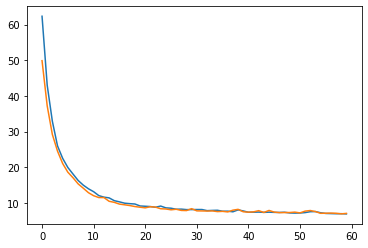

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

In [12]:
def mape(a, b):
    a, b = np.array(a), np.array(b)
    mask = a != 0
    return (np.fabs(a - b)/a)[mask].mean()

After successful training, the model ist tested on the test datset:

In [13]:
plt.rcParams["figure.figsize"] = (150, 6)

from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#function to plot true values vs. the predicted ones
#if rider is still active no true value is plotted and excluded from the metrics

def plot_pred_true(X, Y, used_model=model):
    y_pred = np.ma.compressed(
        np.ma.masked_where(X[:,:,0].flatten() == -99,
                           used_model.predict(X).round(1).flatten()))
    y_true = np.ma.compressed(np.ma.masked_where(X[:,:,0].flatten() == -99,
                                                 Y[:,:,0].flatten()))
    y_true[y_true == -99] = np.nan
    plt.rcParams["figure.figsize"] = (150, 6)
    plt.plot(y_pred, label="Predicted")
    plt.plot(y_true, label="True")
    plt.xlabel('Data Points')
    plt.ylabel('Time Until Career-End')
    plt.title('Predictions vs. True Value')
    plt.legend(loc = "lower left")
    plt.show()
    result_df = pd.DataFrame({'true': y_true, 'pred': y_pred})
    result_df = result_df.dropna(how='any')
    score_mae = "{0:.3f}".format(mean_absolute_error(result_df['true'], result_df['pred']))
    score_rmse = "{0:.3f}".format(sqrt(mean_squared_error(result_df['true'], result_df['pred'])))
    score_mape = "{0:.3f}".format(mape(result_df['true'], result_df['pred']))
    score_r2 = "{0:.3f}".format(r2_score(result_df['true'], result_df['pred']))
    score_df = pd.DataFrame([score_mae, score_rmse, score_mape, score_r2],
                            columns=['Metrics'],
                            index=['MAE', 'RMSE', 'MAPE', 'R2'])
    plt.rcParams["figure.figsize"] = (10, 10)
    plt.scatter(result_df['true'], result_df['pred'])
    plt.plot( [0,result_df['true'].max()],[0,result_df['true'].max()], c='b')
    plt.xlabel('True time till end of Career')
    plt.ylabel('Predicted time till end of Career')
    plt.show()
    return score_df

The results on the test set show, that the model is performing acceptable. The model is on average off by 1.8 years and according to the R-squared metric explains 74% of the variance of the target variable.  
The scatterplot shows, that the model tends to under-estimate the time left of a carreer in the first years of a rider's career and tends to over-estimate the closer a rider comes to his end of career.  

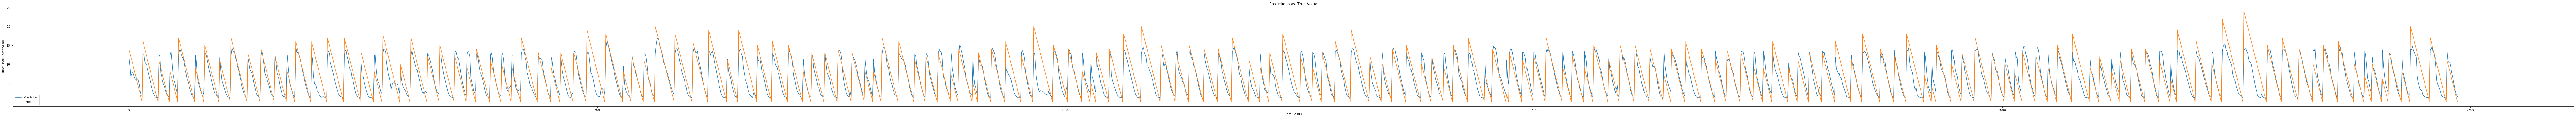

/anaconda3/envs/my_conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


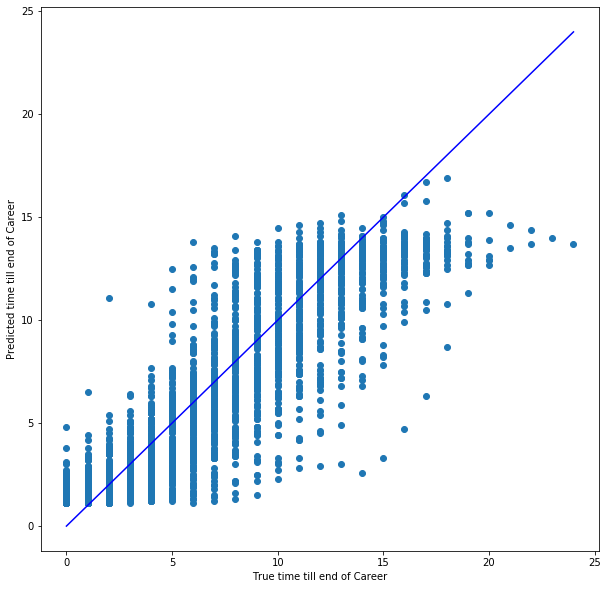

Metrics
MAE    1.820
RMSE   2.426
MAPE   0.310
R2     0.742

In [14]:
plot_pred_true(test_X, test_Y)

In [27]:
#function to plot the predicted end of career from riders who are still active
#and to copy the predicted values into a master dataframe
def make_pred(X, Y, master_df, used_model = model):
    predicted_val = np.ma.compressed(np.ma.masked_where(X[:,:,0].flatten() == -99,
                       used_model.predict(X).round(1).flatten()))
    plt.rcParams["figure.figsize"] = (800, 6)
    plt.plot(predicted_val,
             label="Predicted")
    plt.show()
    y_true = np.ma.compressed(np.ma.masked_where(X[:,:,0].flatten() == -99,
                                                 Y[:,:,0].flatten()))
    y_true[y_true == -99] = np.nan
    
    Results = master_df
    Results = Results[['IDs', 'Name', 'Nationality','Team', 'Season', 'Stats Points', 'Stats Wins', 'Stats Racedays',
       'Stats Top-10s', 'Age']]
    Results['Predicted'] = predicted_val
    Results['True Value'] = y_true
    Results = Results[Results['Name'] != 0]
    Results = Results.dropna(subset=['Predicted', 'True Value'], how='all')
    Results = Results.sort_values(by=['Name', 'Season'])
    return Results
    

In [24]:
lookup_data

Season   IDs    ID_x  Stats Season  Stats KMs  Stats Points  \
0        1986     0     0.0        1986.0      172.0          70.0   
1        1987     0     0.0        1987.0      546.0          84.0   
2        1988     0     0.0        1988.0        0.0           0.0   
3        1989     0     0.0           0.0        0.0           0.0   
4        1990     0     0.0           0.0        0.0           0.0   
...       ...   ...     ...           ...        ...           ...   
18837    1993  1357  1357.0        1993.0     3184.0         100.0   
18838    1994  1357  1357.0        1994.0     4376.0         270.0   
18839    1995  1357  1357.0        1995.0     2282.0         114.0   
18840    1996  1357     0.0           0.0        0.0           0.0   
18841    1997  1357  1357.0        1997.0      188.0           0.0   

       Stats Wins  Stats Racedays  Stats Top-10s  Starts GT  ...  TraineeYear  \
0             1.0             2.0            2.0        0.0  ...          0.0   
1             0.0             5.0            3.0        0.0  ...          0.0   
2             0.0             1.0            0.0        0.0  ...          0.0   
3             0.0             0.0            0.0        0.0  ...          0.0   
4             0.0             0.0            0.0        0.0  ...          0.0   
...           ...             ...            ...        ...  ...          ...   
18837         1.0            27.0            4.0        1.0  ...          0.0   
18838         0.0            35.0            7.0        1.0  ...          0.0   
18839         1.0            21.0            3.0        1.0  ...          0.0   
18840         0.0             0.0            0.0        0.0  ...          0.0   
18841         0.0             1.0            0.0        0.0  ...          0.0   

        CT  PCT   WT  CareerLength start  stop    Age event UntilEvent  
0      0.0  0.0  0.0             1     0     1  22.05     0         14  
1      0.0  0.0  0.0             2     1     2  23.05     0         13  
2      0.0  0.0  0.0             3     2     3  24.06     0         12  
3      0.0  0.0  0.0             4     3     4  25.06     0         11  
4      0.0  0.0  0.0             5     4     5  26.06     0         10  
...    ...  ...  ...           ...   ...   ...    ...   ...        ...  
18837  0.0  0.0  0.0             6     5     6  25.74     0          4  
18838  0.0  0.0  0.0             7     6     7  26.74     1          3  
18839  0.0  0.0  0.0             8     7     8  27.74     0          2  
18840  0.0  0.0  0.0             9     8     9  28.74     0          1  
18841  0.0  0.0  0.0            10     9    10  29.74     0          0  

[18842 rows x 41 columns]

With above function, the model is used to predict the time until the end of career for all riders (also the still active ones) from the available data.

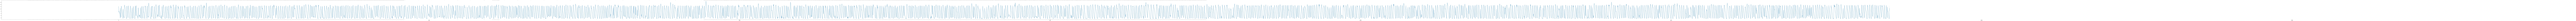

/anaconda3/envs/my_conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda3/envs/my_conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [28]:
results = make_pred(all_X,all_Y, lookup_data)


As the plot above is not very useful for interpretation, the result dataframe can be explorred via an interactive jupyter widget. Try it out and look at the model's predictions for your favourite rider:  

Dropdown(description='Rider', index=1034, options=('Aart Vierhouten', 'Abraham Olano', 'Adam Hansen', 'Adam Ya…

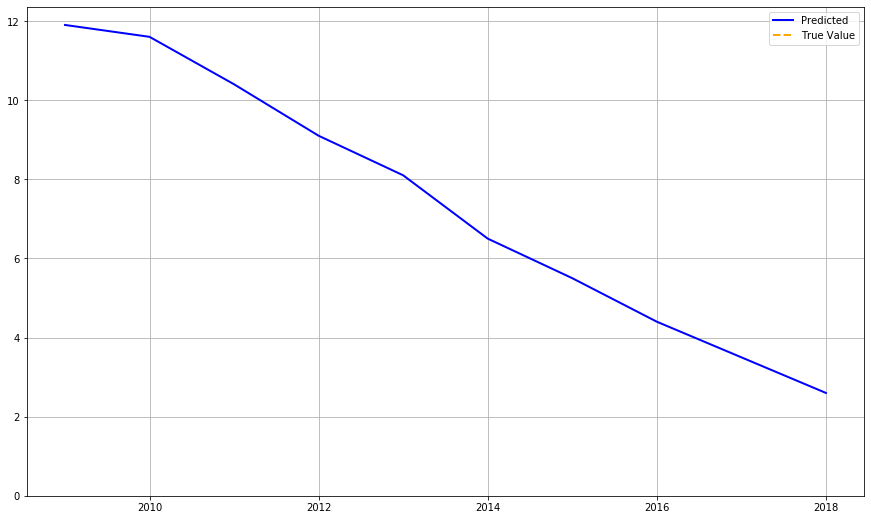

In [30]:
#widget to interactively plot a riders true vs predicted RUL curves
from IPython.display import display, clear_output
import ipywidgets as widgets
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (15, 9)

mydata = results
default = 'Peter Sagan'
plt_data = mydata[['Season', 'Predicted', 'True Value']][mydata['Name'] == default]
plt.plot('Season', 'Predicted', data=plt_data, color='blue', linewidth=2)
plt.plot('Season', 'True Value', data=plt_data, color='orange', linewidth=2, linestyle='dashed')
plt.legend()
axes = plt.gca()
axes.set_ylim([0, None])
axes.grid(True)

w = widgets.Dropdown(
    options=mydata['Name'].unique(),
    value = default,
    description='Rider')
display(w)

def on_change(change):
    if change['name'] == 'value' and (change['new'] != change['old']):
        clear_output()
        display(w)
        plt_data = mydata[['Season', 'Predicted', 'True Value']][mydata['Name'] == change['new']]
        plt.plot('Season', 'Predicted', data=plt_data, color='blue', linewidth=2)
        plt.plot('Season', 'True Value', data=plt_data, color='orange', linewidth=2, linestyle='dashed')
        plt.legend()
        axes = plt.gca()
        axes.set_ylim([0, None])
        axes.grid(True)
        

w.observe(on_change)